# AutoML: Train "the best" Image Object Detection model for a 'identifying components' for construction takeoff scenario.

**Requirements** - In order to benefit from this tutorial, you will need:
- A basic understanding of Machine Learning
- An Azure account with an active subscription. [Create an account for free](https://azure.microsoft.com/free/?WT.mc_id=A261C142F)
- An Azure ML workspace. [Check this notebook for creating a workspace](../../../resources/workspace/workspace.ipynb) 
- A Compute Cluster. [Check this notebook to create a compute cluster](../../../resources/compute/compute.ipynb)
- A python environment
- Installed Azure Machine Learning Python SDK v2 - [install instructions](../../../README.md) - check the getting started section

**Learning Objectives** - By the end of this tutorial, you should be able to:
- Connect to your AML workspace from the Python SDK
- Create an `AutoML Image Object Detection Training Job` with the 'image_object_detection()' factory-function.
- Train the model using AmlCompute by submitting/running the AutoML training job
- Obtaing the model and score predictions with it

**Motivations** - This notebook explains how to setup and run an AutoML image object detection job. This is one of the nine ML-tasks supported by AutoML. Other ML-tasks are 'forecasting', 'classification', 'image object detection', 'nlp text classification', etc.

In this notebook, we go over how you can use AutoML for training an Image Object Detection model. We will use a small dataset to train the model, demonstrate how you can tune hyperparameters of the model to optimize model performance and deploy the model to use in inference scenarios. 

# 1. Connect to Azure Machine Learning Workspace

The [workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-workspace) is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning. In this section we will connect to the workspace in which the job will be run.

## 1.1. Import the required libraries

In [1]:
# Import required libraries
from azure.identity import DefaultAzureCredential, DeviceCodeCredential
from azure.ai.ml import MLClient

from azure.ai.ml.automl import SearchSpace, ObjectDetectionPrimaryMetrics
from azure.ai.ml.sweep import (
    Choice,
    Uniform,
    BanditPolicy,
)

from azure.ai.ml import automl

## 1.2. Configure workspace details and get a handle to the workspace

To connect to a workspace, we need identifier parameters - a subscription, resource group and workspace name. We will use these details in the `MLClient` from `azure.ai.ml` to get a handle to the required Azure Machine Learning workspace. We use the default [default azure authentication](https://docs.microsoft.com/en-us/python/api/azure-identity/azure.identity.defaultazurecredential?view=azure-python) for this tutorial. Check the [configuration notebook](../../configuration.ipynb) for more details on how to configure credentials and connect to a workspace.

In [6]:
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential

try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
    ml_client = MLClient.from_config(credential=credential)
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    # This will open a browser page for
    credential = InteractiveBrowserCredential()

Found the config file in: /mnt/c/source/repos/.azureml/config.json


In [5]:
try:
    ml_client = MLClient.from_config(credential=credential)
except Exception as ex:
    # NOTE: Update following workspace information if not correctly configure before
    client_config = {
        "subscription_id": "840b5c5c-3f4a-459a-94fc-6bad2a969f9d",
        "resource_group": "ml",
        "workspace_name": "ws02ent",
    }

    if client_config["subscription_id"].startswith("<"):
        print(
            "please update your <SUBSCRIPTION_ID> <RESOURCE_GROUP> <AML_WORKSPACE_NAME> in notebook cell"
        )
        raise ex
    else:  # write and reload from config file
        import json, os

        config_path = "../.azureml/config.json"
        os.makedirs(os.path.dirname(config_path), exist_ok=True)
        with open(config_path, "w") as fo:
            fo.write(json.dumps(client_config))
        ml_client = MLClient.from_config(credential=credential, path=config_path)
print(ml_client)

Found the config file in: ../.azureml/config.json


MLClient(credential=<azure.identity._credentials.default.DefaultAzureCredential object at 0x7f3fb4462fa0>,
         subscription_id=840b5c5c-3f4a-459a-94fc-6bad2a969f9d,
         resource_group_name=ml,
         workspace_name=ws02ent)


# 2. MLTable with input Training Data

In order to generate models for computer vision tasks with automated machine learning, you need to bring labeled image data as input for model training in the form of an MLTable. You can create an MLTable from labeled training data in JSONL format. If your labeled training data is in a different format (like, pascal VOC or COCO), you can use a conversion script to first convert it to JSONL, and then create an MLTable. Alternatively, you can use Azure Machine Learning's [data labeling tool](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-create-image-labeling-projects) to manually label images, and export the labeled data to use for training your AutoML model.

In this notebook, we use a toy dataset called Fridge Objects, which consists of 128 images of 4 labels of beverage container {`can`, `carton`, `milk bottle`, `water bottle`} photos taken on different backgrounds.

All images in this notebook are hosted in [this repository](https://github.com/microsoft/computervision-recipes) and are made available under the [MIT license](https://github.com/microsoft/computervision-recipes/blob/master/LICENSE).

## 2.1. Download the Data
We first download and unzip the data locally. By default, the data would be downloaded in `./data` folder in current directory. 
If you prefer to download the data at a different location, update it in `dataset_parent_dir = ...` in the next cell.

In [7]:
import os
import urllib
from zipfile import ZipFile

# Change to a different location if you prefer
dataset_parent_dir = "./labeling-image-data"

# create data folder if it doesnt exist.
#os.makedirs(dataset_parent_dir, exist_ok=True)

# download data
#download_url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip"

# Extract current dataset name from dataset url
#dataset_name = os.path.split(download_url)[-1].split(".")[0]
dataset_name = "augmented-samples"
# Get dataset path for later use
dataset_dir = os.path.join(dataset_parent_dir, dataset_name)
print(dataset_dir)
# Get the data zip file path
#data_file = os.path.join(dataset_parent_dir, f"{dataset_name}.zip")

# Download the dataset
#urllib.request.urlretrieve(download_url, filename=data_file)

# extract files
#with ZipFile(data_file, "r") as zip:
#    print("extracting files...")
#    zip.extractall(path=dataset_parent_dir)
#    print("done")
# delete zip file
#os.remove(data_file)

./labeling-image-data/augmented-samples


This is a sample image from this dataset:

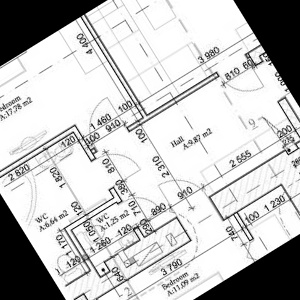

In [8]:
from IPython.display import Image

sample_image = os.path.join(dataset_dir, "images", "set4_rotated_augmented_As-built.jpg")
Image(filename=sample_image)

## 2.2. Upload the images to Datastore through an AML Data asset (URI Folder)

In order to use the data for training in Azure ML, we upload it to our default Azure Blob Storage of our  Azure ML Workspace.

[Check this notebook for AML data asset example](../../../assets/data/data.ipynb)

In [9]:
# Uploading image files by creating a 'data asset URI FOLDER':

from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml import Input

my_data = Data(
    path=dataset_dir,
    type=AssetTypes.URI_FOLDER,
    description="construction plans",
    name="construction-plans",
)

#uri_folder_data_asset = ml_client.data.create_or_update(my_data)
uri_folder_data_asset = ml_client.data.get(name="construction-plans", version="1")

print(uri_folder_data_asset)
print("")
print("Path to folder in Blob Storage:")
print(uri_folder_data_asset.path)

creation_context:
  created_at: '2023-10-12T03:03:44.638098+00:00'
  created_by: Anil Dwarakanath
  created_by_type: User
  last_modified_at: '2023-10-12T03:03:44.648021+00:00'
description: construction plans
id: /subscriptions/840b5c5c-3f4a-459a-94fc-6bad2a969f9d/resourceGroups/ml/providers/Microsoft.MachineLearningServices/workspaces/ws02ent/data/construction-plans/versions/1
name: construction-plans
path: azureml://subscriptions/840b5c5c-3f4a-459a-94fc-6bad2a969f9d/resourcegroups/ml/workspaces/ws02ent/datastores/workspaceblobstore/paths/LocalUpload/2ebf66653fa08296cec0b5f86a9d59ab/augmented-samples/
properties: {}
tags: {}
type: uri_folder
version: '1'


Path to folder in Blob Storage:
azureml://subscriptions/840b5c5c-3f4a-459a-94fc-6bad2a969f9d/resourcegroups/ml/workspaces/ws02ent/datastores/workspaceblobstore/paths/LocalUpload/2ebf66653fa08296cec0b5f86a9d59ab/augmented-samples/


In [10]:
# Uploading image files by creating a 'data asset URI FOLDER':

from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml import Input

drawing_labels_coco_data = Data(
    path="./coco",
    type=AssetTypes.URI_FOLDER,
    description="construction_drawing_coco_labeled.json",
    name="construction_drawing_coco_labeled",
)

#drawing_labels_coco_data_asset = ml_client.data.create_or_update(drawing_labels_coco_data)
drawing_labels_coco_data_asset = ml_client.data.get(name="construction_drawing_coco_labeled", version="1")

print(drawing_labels_coco_data_asset)
print("")
print("Path to folder in Blob Storage:")
print(drawing_labels_coco_data_asset.path)

creation_context:
  created_at: '2023-10-12T03:10:36.262425+00:00'
  created_by: Anil Dwarakanath
  created_by_type: User
  last_modified_at: '2023-10-12T03:10:36.272563+00:00'
description: construction_drawing_coco_labeled.json
id: /subscriptions/840b5c5c-3f4a-459a-94fc-6bad2a969f9d/resourceGroups/ml/providers/Microsoft.MachineLearningServices/workspaces/ws02ent/data/construction_drawing_coco_labeled/versions/1
name: construction_drawing_coco_labeled
path: azureml://subscriptions/840b5c5c-3f4a-459a-94fc-6bad2a969f9d/resourcegroups/ml/workspaces/ws02ent/datastores/workspaceblobstore/paths/LocalUpload/0dac4821b39deeef2c010b62a868cea6/coco/
properties: {}
tags: {}
type: uri_folder
version: '1'


Path to folder in Blob Storage:
azureml://subscriptions/840b5c5c-3f4a-459a-94fc-6bad2a969f9d/resourcegroups/ml/workspaces/ws02ent/datastores/workspaceblobstore/paths/LocalUpload/0dac4821b39deeef2c010b62a868cea6/coco/


In [11]:
drawing_labels_coco_data_asset.path

'azureml://subscriptions/840b5c5c-3f4a-459a-94fc-6bad2a969f9d/resourcegroups/ml/workspaces/ws02ent/datastores/workspaceblobstore/paths/LocalUpload/0dac4821b39deeef2c010b62a868cea6/coco/'

In [12]:
dataset_parent_dir

'./labeling-image-data'

In [179]:
import sys

sys.path.insert(0, "./jsonl-conversion/")
from base_jsonl_converter import write_json_lines
from coco_jsonl_converter import COCOJSONLConverter

base_url = os.path.join(uri_folder_data_asset.path, "images/")
print(base_url)
converter = COCOJSONLConverter(base_url, "./coco/construction_drawing_coco_labeled.json")
jsonl_annotations = os.path.join(dataset_parent_dir, "annotations", "construction_drawing_coco_labeled.jsonl")
write_json_lines(converter, jsonl_annotations)

azureml://subscriptions/840b5c5c-3f4a-459a-94fc-6bad2a969f9d/resourcegroups/ml/workspaces/ws02ent/datastores/workspaceblobstore/paths/LocalUpload/2ebf66653fa08296cec0b5f86a9d59ab/augmented-samples/images/
Conversion completed. Converted 159 lines.


In [180]:
import os

# We'll copy each JSONL file within its related MLTable folder
training_mltable_path = os.path.join(dataset_parent_dir, "training-mltable-folder")
validation_mltable_path = os.path.join(dataset_parent_dir, "validation-mltable-folder")

# First, let's create the folders if they don't exist
os.makedirs(training_mltable_path, exist_ok=True)
os.makedirs(validation_mltable_path, exist_ok=True)

train_validation_ratio = 5

# Path to the training and validation files
train_annotations_file = os.path.join(training_mltable_path, "train_annotations.jsonl")
validation_annotations_file = os.path.join(
    validation_mltable_path, "validation_annotations.jsonl"
)

with open(jsonl_annotations, "r") as annot_f:
    json_lines = annot_f.readlines()

index = 0
with open(train_annotations_file, "w") as train_f:
    with open(validation_annotations_file, "w") as validation_f:
        for json_line in json_lines:
            if index % train_validation_ratio == 0:
                # validation annotation
                validation_f.write(json_line)
            else:
                # train annotation
                train_f.write(json_line)
            index += 1

### Visualize bounding boxes
Please refer to the "Visualize data" section in the following [tutorial](https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-auto-train-image-models#visualize-data) to see how to easily visualize your ground truth bounding boxes before starting to train.

In [181]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image as pil_image
import numpy as np
import json
import os

def plot_ground_truth_boxes(image_file, ground_truth_boxes):
    # Display the image
    plt.figure()
    img_np = mpimg.imread(image_file)
    img = pil_image.fromarray(img_np.astype("uint8"), "RGB")
    img_w, img_h = img.size

    fig,ax = plt.subplots(figsize=(12, 16))
    ax.imshow(img_np)
    ax.axis("off")

    label_to_color_mapping = {}

    for gt in ground_truth_boxes:
        label = gt["label"]

        xmin, ymin, xmax, ymax =  gt["topX"], gt["topY"], gt["bottomX"], gt["bottomY"]
        topleft_x, topleft_y = img_w * xmin, img_h * ymin
        width, height = img_w * (xmax - xmin), img_h * (ymax - ymin)

        if label in label_to_color_mapping:
            color = label_to_color_mapping[label]
        else:
            # Generate a random color. If you want to use a specific color, you can use something like "red".
            color = np.random.rand(3)
            label_to_color_mapping[label] = color

        # Display bounding box
        rect = patches.Rectangle((topleft_x, topleft_y), width, height,
                                 linewidth=2, edgecolor=color, facecolor="none")
        ax.add_patch(rect)

        # Display label
        ax.text(topleft_x, topleft_y - 10, label, color=color, fontsize=20)

    plt.show()

def plot_ground_truth_boxes_jsonl(image_file, jsonl_file):
    image_base_name = os.path.basename(image_file)
    ground_truth_data_found = False
    with open(jsonl_file) as fp:
        for line in fp.readlines():
            line_json = json.loads(line)
            filename = line_json["image_url"]
            if image_base_name in filename:
                ground_truth_data_found = True
                plot_ground_truth_boxes(image_file, line_json["label"])
                break
    if not ground_truth_data_found:
        print("Unable to find ground truth information for image: {}".format(image_file))

<Figure size 640x480 with 0 Axes>

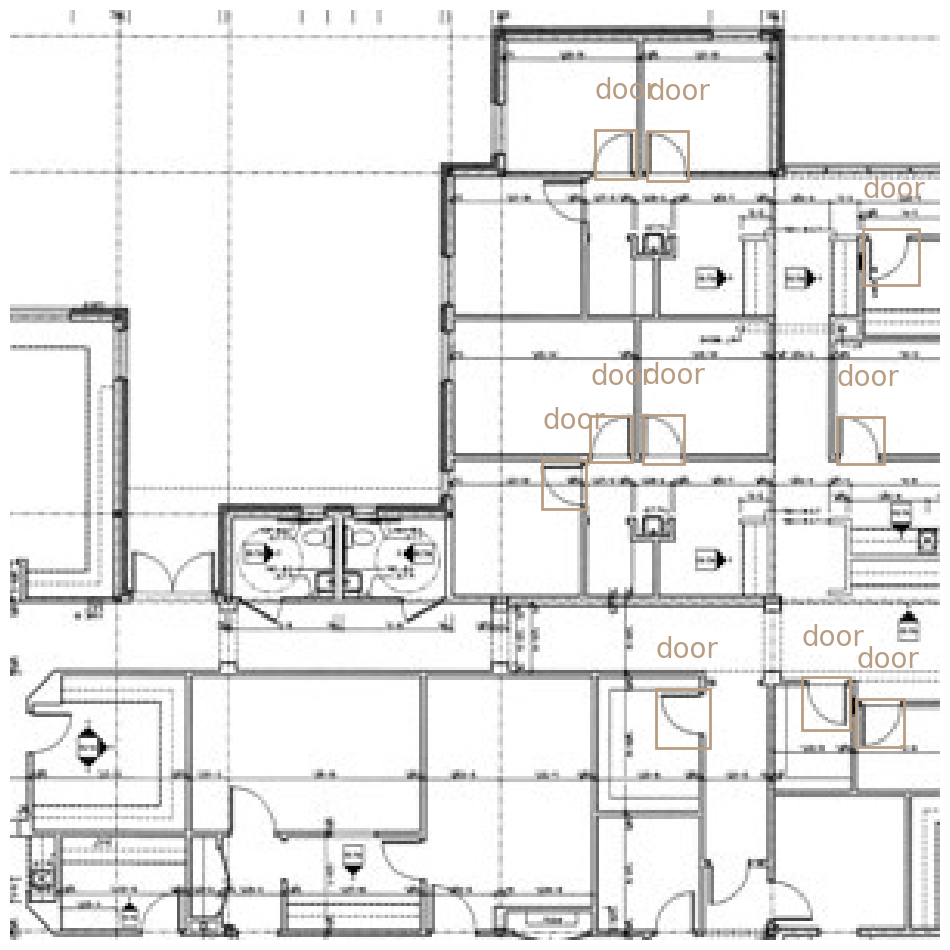

In [182]:
image_file = f"./{dataset_parent_dir}/augmented-samples/images/set1_flipped_augmented_As-built-drawings.jpg"
jsonl_file = f"./{dataset_parent_dir}/annotations/construction_drawing_coco_labeled.jsonl"

plot_ground_truth_boxes_jsonl(image_file, jsonl_file)

## 2.5. Create MLTable data input
Create MLTable data input using the jsonl files created above.

For documentation on creating your own MLTable assets for jobs beyond this notebook, please refer to below resources
- [MLTable YAML Schema](https://learn.microsoft.com/en-us/azure/machine-learning/reference-yaml-mltable) - covers how to write MLTable YAML, which is required for each MLTable asset.
- [Create MLTable data asset](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-create-data-assets?tabs=Python-SDK#create-a-mltable-data-asset) - covers how to create MLTable data asset. 

In [183]:
def create_ml_table_file(filename):
    """Create ML Table definition"""

    return (
        "paths:\n"
        "  - file: ./{0}\n"
        "transformations:\n"
        "  - read_json_lines:\n"
        "        encoding: utf8\n"
        "        invalid_lines: error\n"
        "        include_path_column: false\n"
        "  - convert_column_types:\n"
        "      - columns: image_url\n"
        "        column_type: stream_info"
    ).format(filename)


def save_ml_table_file(output_path, mltable_file_contents):
    with open(os.path.join(output_path, "MLTable"), "w") as f:
        f.write(mltable_file_contents)


# Create and save train mltable
train_mltable_file_contents = create_ml_table_file(
    os.path.basename(train_annotations_file)
)
save_ml_table_file(training_mltable_path, train_mltable_file_contents)

# Save train and validation mltable
validation_mltable_file_contents = create_ml_table_file(
    os.path.basename(validation_annotations_file)
)
save_ml_table_file(validation_mltable_path, validation_mltable_file_contents)

In [184]:
# Training MLTable defined locally, with local data to be uploaded
my_training_data_input = Input(type=AssetTypes.MLTABLE, path=training_mltable_path)

# Validation MLTable defined locally, with local data to be uploaded
my_validation_data_input = Input(type=AssetTypes.MLTABLE, path=validation_mltable_path)

# WITH REMOTE PATH: If available already in the cloud/workspace-blob-store
# my_training_data_input = Input(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/train")
# my_validation_data_input = Input(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/valid")

To create data input from TabularDataset created using V1 sdk, specify the `type` as `AssetTypes.MLTABLE`, `mode` as `InputOutputModes.DIRECT` and `path` in the following format `azureml:<tabulardataset_name>:<version>`.

In [ ]:
"""
# Training MLTable with v1 TabularDataset
my_training_data_input = Input(
    type=AssetTypes.MLTABLE, path="azureml:odFridgeObjectsTrainingDataset:1",
    mode=InputOutputModes.DIRECT
)

# Validation MLTable with v1 TabularDataset
my_validation_data_input = Input(
    type=AssetTypes.MLTABLE, path="azureml:odFridgeObjectsValidationDataset:1",
    mode=InputOutputModes.DIRECT
)
"""

# 3. Compute target setup

We will need to provide a [Compute Target](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#computes) that will be used for your AutoML model training. AutoML models for image tasks require [GPU SKUs](https://docs.microsoft.com/en-us/azure/virtual-machines/sizes-gpu) such as the ones from the NC, NCv2, NCv3, ND, NDv2 and NCasT4 series. We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [185]:
from azure.ai.ml.entities import AmlCompute
from azure.core.exceptions import ResourceNotFoundError

compute_name = "gpu-cluster-a100"

try:
    _ = ml_client.compute.get(compute_name)
    print("Found existing compute target.")
except ResourceNotFoundError:
    print("Creating a new compute target...")
    compute_config = AmlCompute(
        name=compute_name,
        type="amlcompute",
        size="Standard_NC6s_v3",
        idle_time_before_scale_down=120,
        min_instances=0,
        max_instances=4,
    )
    ml_client.begin_create_or_update(compute_config).result()

Found existing compute target.


# 4. Configure and run the AutoML for Images Object Detection training job

AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm and hyperparameters to be used, perform a sweep over a manually specified hyperparameter space, or the system can automatically perform a hyperparameter sweep for you.


## 4.1. Automatic hyperparameter sweeping for your models (AutoMode)

When using AutoML for Images, we can perform an automatic hyperparameter sweep to find the optimal model (we call this functionality AutoMode). The system will choose a model architecture and values for the learning_rate, number_of_epochs, training_batch_size, etc. based on the number of runs. There is no need to specify the hyperparameter search space, sampling method or early termination policy. A number of runs between 10 and 20 will likely work well on many datasets.

AutoMode is triggered by setting `max_trials` to a value greater than 1 in limits and by omitting the hyperparameter space, sampling method and termination policy.

The following functions configure AutoML image jobs for automatic sweeps:
### image_object_detection() function parameters:
The `image_object_detection()` factory function allows user to configure the training job.

- `compute` - The compute on which the AutoML job will run. In this example we are using a compute called 'gpu-cluster' present in the workspace. You can replace it any other compute in the workspace.
- `experiment_name` - The name of the experiment. An experiment is like a folder with multiple runs in Azure ML Workspace that should be related to the same logical machine learning experiment.
- `name` - The name of the Job/Run. This is an optional property. If not specified, a random name will be generated.
- `primary_metric` - The metric that AutoML will optimize for model selection.
- `target_column_name` - The name of the column to target for predictions. It must always be specified. This parameter is applicable to 'training_data' and 'validation_data'.
- `training_data` - The data to be used for training. It should contain both training feature columns and a target column. Optionally, this data can be split for segregating a validation or test dataset. 
You can use a registered MLTable in the workspace using the format '<mltable_name>:<version>' OR you can use a local file or folder as a MLTable. For e.g Input(mltable='my_mltable:1') OR Input(mltable=MLTable(local_path="./data"))
The parameter `training_data` must always be provided.

### set_limits() function parameters:
This is an optional configuration method to configure limits parameters such as timeouts.

- `timeout_minutes` - Maximum amount of time in minutes that the whole AutoML job can take before the job terminates. If not specified, the default job's total timeout is 6 days (8,640 minutes).
- `max_trials` - Parameter for maximum number of configurations to sweep. Must be an integer between 1 and 1000. When exploring just the default hyperparameters for a given model algorithm, set this parameter to 1. Default value is 1.
- `max_concurrent_trials` - Maximum number of runs that can run concurrently. If not specified, all runs launch in parallel. If specified, must be an integer between 1 and 100. Default value is 1.
    NOTE: The number of concurrent runs is gated on the resources available in the specified compute target. Ensure that the compute target has the available resources for the desired concurrency.



In [201]:
# general job parameters
exp_name = "construction-plan-object-detection-experiment-with-tiling"

In [204]:
# Create the AutoML job with the related factory-function.

image_object_detection_job = automl.image_object_detection(
    compute=compute_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
    primary_metric="mean_average_precision",
    tags={"my_custom_tag": "My custom value"},
)

image_object_detection_job.set_limits(
    max_trials=10,
    max_concurrent_trials=1,
)

#image_object_detection_job.set_training_parameters(
#    tile_grid_size='5x3'
#)

image_object_detection_job.extend_search_space(
    SearchSpace(
        model_name=Choice(['fasterrcnn_resnet50_fpn']),
        tile_grid_size=Choice(['5x3'])
    )
)

### Submitting an AutoML job for Computer Vision tasks
Once you've configured your job, you can submit it as a job in the workspace in order to train a vision model using your training dataset.

In [205]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    image_object_detection_job
)  # submit the job to the backend

print(f"Created job: {returned_job}")

Created job: compute: azureml:gpu-cluster-a100
creation_context:
  created_at: '2023-10-12T06:02:49.359288+00:00'
  created_by: Anil Dwarakanath
  created_by_type: User
display_name: modest_sun_khtgzptgs8
experiment_name: construction-plan-object-detection-experiment-with-tiling
id: azureml:/subscriptions/840b5c5c-3f4a-459a-94fc-6bad2a969f9d/resourceGroups/ml/providers/Microsoft.MachineLearningServices/workspaces/ws02ent/jobs/modest_sun_khtgzptgs8
limits:
  max_concurrent_trials: 1
  max_trials: 10
  timeout_minutes: 10080
log_verbosity: info
name: modest_sun_khtgzptgs8
outputs: {}
primary_metric: mean_average_precision
properties:
  azureml.git.dirty: 'True'
  mlflow.source.git.branch: main
  mlflow.source.git.commit: e5f7b247d4753f115a8f7da30cbe25294f71f9d7
  mlflow.source.git.repoURL: https://github.com/Azure/azureml-examples
resources:
  instance_count: 1
  shm_size: 2g
search_space:
- model_name:
    type: choice
    values:
    - fasterrcnn_resnet50_fpn
  tile_grid_size:
    type

In [206]:
ml_client.jobs.stream(returned_job.name)

RunId: modest_sun_khtgzptgs8
Web View: https://ml.azure.com/runs/modest_sun_khtgzptgs8?wsid=/subscriptions/840b5c5c-3f4a-459a-94fc-6bad2a969f9d/resourcegroups/ml/workspaces/ws02ent



Execution Summary
RunId: modest_sun_khtgzptgs8
Web View: https://ml.azure.com/runs/modest_sun_khtgzptgs8?wsid=/subscriptions/840b5c5c-3f4a-459a-94fc-6bad2a969f9d/resourcegroups/ml/workspaces/ws02ent



## 4.2. Individual runs

If AutoMode does not meet your needs, you can launch individual runs to explore model algorithms; we provide sensible default hyperparameters for each algorithm. You can also launch individual runs for the same model algorithm and different hyperparameter combinations. The model algorithm is specified using the model_name parameter. Please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=CLI-v2#configure-model-algorithms-and-hyperparameters) for the list of supported model algorithms.

The following function can be used to configure AutoML jobs for individual runs:
### set_training_parameters() function parameters:
This is an optional configuration method to configure fixed settings or parameters that don't change during the parameter space sweep. Some of the key parameters of this function are:

- `model_name` - The name of the ML algorithm that we want to use in training job. Please refer to this [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=CLI-v2#supported-model-algorithms) for supported model algorithm.
- `number_of_epochs` - The number of training epochs. It must be positive integer (default value is 15).
- `layers_to_freeze` - The number of layers to freeze in model for transfer learning. It must be a positive integer (default value is 0).
- `early_stopping` - It enable early stopping logic during training, It must be boolean value (default is True).   
- `optimizer` - Type of optimizer to use in training. It must be either sgd, adam, adamw (default is sgd).
- `distributed` - It enable distributed training if compute target contain multiple GPUs. It must be boolean value (default is True).

If you wish to use the default hyperparameter values for a given algorithm (say `yolov5`), you can specify the job for your AutoML Image runs as follows:

In [ ]:
# Create the AutoML job with the related factory-function.

image_object_detection_job = automl.image_object_detection(
    compute=compute_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
)

# Set limits
image_object_detection_job.set_limits(timeout_minutes=60)

# Pass the fixed settings or parameters
image_object_detection_job.set_training_parameters(model_name="yolov5")

In [ ]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(image_object_detection_job)

print(f"Created job: {returned_job}")

In [ ]:
ml_client.jobs.stream(returned_job.name)

### 4.2.1 Individual runs with models from MMDetection (Preview)

In addition to the models supported natively by AutoML, you can launch individual runs to explore any model from MMDetection version 2.28.2 that supports object detection. Please refer to this [documentation](https://github.com/open-mmlab/mmdetection/blob/v2.28.2/docs/en/model_zoo.md) for the list of models.

While you can use any model from MMDetection to support this task, we have curated a set of models in our registry. We provide a set of sensible default hyperparameters for these models. You can fetch the list of curated models using code snippet below.

In [ ]:
registry_ml_client = MLClient(credential, registry_name="azureml")

models = registry_ml_client.models.list()
object_detection_models = []
for model in models:
    try:
        model = registry_ml_client.models.get(model.name, label="latest")
        if model.tags.get("task", "") == "object-detection":
            object_detection_models.append(model.name)
    except Exception as ex:
        print(f"Error while accessing registry model list: {ex}")

object_detection_models

If you wish to try a model (say `vfnet_r50_fpn_mdconv_c3-c5_mstrain_2x_coco`), you can specify the job for your AutoML Image runs as follows:

In [ ]:
# Create the AutoML job with the related factory-function.

image_object_detection_job = automl.image_object_detection(
    compute=compute_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
)

# Set limits
image_object_detection_job.set_limits(timeout_minutes=60)

# Pass the fixed settings or parameters
image_object_detection_job.set_training_parameters(
    model_name="vfnet_r50_fpn_mdconv_c3-c5_mstrain_2x_coco"
)

In [ ]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(image_object_detection_job)

print(f"Created job: {returned_job}")

In [ ]:
ml_client.jobs.stream(returned_job.name)

## 4.3. Manual hyperparameter sweeping for your model

When using AutoML for Images, you can perform a hyperparameter sweep over a defined parameter space to find the optimal model. In this example, we sweep over the hyperparameters for `yolov5` and `fasterrcnn_resnet50_fpn` models, both of which are pretrained on COCO, a large-scale object detection, segmentation, and captioning dataset that contains over 200K labeled images with over 80 label categories, choosing from a range of values for learning_rate, optimizer, lr_scheduler, etc., to generate a model with the optimal 'mean_average_precision'. If hyperparameter values are not specified, then default values are used for the specified algorithm.

set_sweep function is used to configure the sweep settings:
### set_sweep() parameters:
- `sampling_algorithm` - Sampling method to use for sweeping over the defined parameter space. Please refer to this [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=SDK-v2#sampling-methods-for-the-sweep) for list of supported sampling methods.
- `early_termination` - Early termination policy to end poorly performing runs. If no termination policy is specified, all configurations are run to completion. Please refer to this [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=SDK-v2#early-termination-policies) for supported early termination policies.

We use Random Sampling to pick samples from this parameter space and try a total of 10 iterations with these different samples, running 2 iterations at a time on our compute target. Please note that the more parameters the space has, the more iterations you need to find optimal models.

We leverage the Bandit early termination policy which will terminate poor performing configs (those that are not within 20% slack of the best performing config), thus significantly saving compute resources.

For more details on model and hyperparameter sweeping, please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-tune-hyperparameters).

In [ ]:
# Create the AutoML job with the related factory-function.

image_object_detection_job = automl.image_object_detection(
    compute=compute_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
    primary_metric=ObjectDetectionPrimaryMetrics.MEAN_AVERAGE_PRECISION,
    tags={"my_custom_tag": "My custom value"},
)

In [ ]:
# Set limits
image_object_detection_job.set_limits(
    timeout_minutes=60,
    max_trials=10,
    max_concurrent_trials=2,
)

In [ ]:
# Pass the fixed settings or parameters
image_object_detection_job.set_training_parameters(
    early_stopping=True, evaluation_frequency=1
)

In [ ]:
# Configure sweep settings
image_object_detection_job.set_sweep(
    sampling_algorithm="random",
    early_termination=BanditPolicy(
        evaluation_interval=2, slack_factor=0.2, delay_evaluation=6
    ),
)

In [ ]:
# Define search space
image_object_detection_job.extend_search_space(
    [
        SearchSpace(
            model_name=Choice(["yolov5"]),
            learning_rate=Uniform(0.0001, 0.01),
            model_size=Choice(["small", "medium"]),  # model-specific
            # image_size=Choice(640, 704, 768),  # model-specific; might need GPU with large memory
        ),
        SearchSpace(
            model_name=Choice(["fasterrcnn_resnet50_fpn"]),
            learning_rate=Uniform(0.0001, 0.001),
            optimizer=Choice(["sgd", "adam", "adamw"]),
            min_size=Choice([600, 800]),  # model-specific
            # warmup_cosine_lr_warmup_epochs=Choice([0, 3]),
        ),
    ]
)

In [ ]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    image_object_detection_job
)  # submit the job to the backend

print(f"Created job: {returned_job}")

In [ ]:
ml_client.jobs.stream(returned_job.name)

When doing a hyperparameter sweep, it can be useful to visualize the different configurations that were tried using the HyperDrive UI. You can navigate to this UI by going to the 'Child jobs' tab in the UI of the main automl image job from above, which is the HyperDrive parent run. Then you can go into the 'Trials' tab of this HyperDrive parent run. Alternatively, here below you can see directly the HyperDrive parent run and navigate to its 'Trials' tab:

In [ ]:
hd_job = ml_client.jobs.get(returned_job.name + "_HD")
hd_job

### 4.3.1 Manual hyperparameter sweeping for models from MMDetection (Preview)

Similar to how you can use any model from MMDetection version 2.28.2 for individual runs, you can also include these models to perform a hyperparameter sweep. You can also choose a combination of models supported natively by [AutoML](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=CLI-v2#configure-model-algorithms-and-hyperparameters) and models from [MMDetection](https://github.com/open-mmlab/mmdetection/blob/v2.28.2/docs/en/model_zoo.md).

In this example, we sweep over `deformable_detr_twostage_refine_r50_16x2_50e_coco`, `sparse_rcnn_r50_fpn_300_proposals_crop_mstrain_480-800_3x_coco`, and `yolov5`, models choosing from a range of values for learning_rate, model_size, etc., to generate a model with the optimal 'MeanAveragePrecision'..

In [ ]:
# Create the AutoML job with the related factory-function.

image_object_detection_job = automl.image_object_detection(
    compute=compute_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
    primary_metric=ObjectDetectionPrimaryMetrics.MEAN_AVERAGE_PRECISION,
    tags={"my_custom_tag": "My custom value"},
)

# Set limits
image_object_detection_job.set_limits(
    timeout_minutes=240,
    max_trials=10,
    max_concurrent_trials=2,
)

# Configure sweep settings
image_object_detection_job.set_sweep(
    sampling_algorithm="random",
    early_termination=BanditPolicy(
        evaluation_interval=2, slack_factor=0.2, delay_evaluation=6
    ),
)

# Define search space
image_object_detection_job.extend_search_space(
    [
        SearchSpace(
            model_name=Choice(["yolov5"]),
            learning_rate=Uniform(0.0001, 0.01),
            model_size=Choice(["small", "medium"]),  # model-specific
        ),
        SearchSpace(
            model_name=Choice(
                [
                    "deformable_detr_twostage_refine_r50_16x2_50e_coco",
                    "sparse_rcnn_r50_fpn_300_proposals_crop_mstrain_480-800_3x_coco",
                ]
            ),
            learning_rate=Uniform(0.00001, 0.0001),
            number_of_epochs=Choice([15, 20]),
        ),
    ]
)

In [ ]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    image_object_detection_job
)  # submit the job to the backend

print(f"Created job: {returned_job}")

In [ ]:
ml_client.jobs.stream(returned_job.name)

# 5. Retrieve the Best Trial (Best Model's trial/run)
Use the MLFLowClient to access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Trial.

## Initialize MLFlow Client

The models and artifacts that are produced by AutoML can be accessed via the MLFlow interface.
Initialize the MLFlow client here, and set the backend as Azure ML, via. the MLFlow Client.

IMPORTANT, you need to have installed the latest MLFlow packages with:

    pip install azureml-mlflow

    pip install mlflow

### Obtain the tracking URI for MLFlow

In [208]:
import mlflow

# Obtain the tracking URL from MLClient
MLFLOW_TRACKING_URI = ml_client.workspaces.get(
    name=ml_client.workspace_name
).mlflow_tracking_uri

print(MLFLOW_TRACKING_URI)

azureml://westus.api.azureml.ms/mlflow/v1.0/subscriptions/840b5c5c-3f4a-459a-94fc-6bad2a969f9d/resourceGroups/ml/providers/Microsoft.MachineLearningServices/workspaces/ws02ent


In [209]:
# Set the MLFLOW TRACKING URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(f"\nCurrent tracking uri: {mlflow.get_tracking_uri()}")


Current tracking uri: azureml://westus.api.azureml.ms/mlflow/v1.0/subscriptions/840b5c5c-3f4a-459a-94fc-6bad2a969f9d/resourceGroups/ml/providers/Microsoft.MachineLearningServices/workspaces/ws02ent


In [210]:
from mlflow.tracking.client import MlflowClient

# Initialize MLFlow client
mlflow_client = MlflowClient()

### Get the AutoML parent Job

In [212]:
job_name = returned_job.name

# Example if providing an specific Job name/ID
# job_name = "salmon_camel_5sdf05xvb3"

# Get the parent run
mlflow_parent_run = mlflow_client.get_run(job_name)

print("Parent Run: ")
print(mlflow_parent_run)

Parent Run: 
<Run: data=<RunData: metrics={'log_loss': 0.2791463677379964,
 'log_loss_train': 0.1979035243920842,
 'mean_average_precision': 0.65302,
 'precision': 0.36049,
 'recall': 0.90769}, params={}, tags={'automl_best_child_run_id': 'modest_sun_khtgzptgs8_HD_0',
 'fit_time_000': 'NaN',
 'is_gpu': 'True',
 'iteration_000': '0',
 'mlflow.rootRunId': 'modest_sun_khtgzptgs8',
 'mlflow.runName': 'modest_sun_khtgzptgs8',
 'mlflow.user': 'Anil Dwarakanath',
 'model_explain_run': 'best_run',
 'my_custom_tag': 'My custom value',
 'pipeline_id_000': 'UnkownPipelineId',
 'predicted_cost_000': '0',
 'run_algorithm_000': '',
 'run_preprocessor_000': '',
 'score_000': '0.71794',
 'training_percent_000': '0'}>, info=<RunInfo: artifact_uri='azureml://westus.api.azureml.ms/mlflow/v2.0/subscriptions/840b5c5c-3f4a-459a-94fc-6bad2a969f9d/resourceGroups/ml/providers/Microsoft.MachineLearningServices/workspaces/ws02ent/experiments/2b5a4eb7-7e9a-46b1-93c3-60eb5a9fc7b9/runs/modest_sun_khtgzptgs8/artifac

In [213]:
# Print parent run tags. 'automl_best_child_run_id' tag should be there.
print(mlflow_parent_run.data.tags)

{'my_custom_tag': 'My custom value', 'model_explain_run': 'best_run', 'is_gpu': 'True', 'pipeline_id_000': 'UnkownPipelineId', 'score_000': '0.71794', 'predicted_cost_000': '0', 'fit_time_000': 'NaN', 'training_percent_000': '0', 'iteration_000': '0', 'run_preprocessor_000': '', 'run_algorithm_000': '', 'automl_best_child_run_id': 'modest_sun_khtgzptgs8_HD_0', 'mlflow.rootRunId': 'modest_sun_khtgzptgs8', 'mlflow.runName': 'modest_sun_khtgzptgs8', 'mlflow.user': 'Anil Dwarakanath'}


### Get the AutoML best child run

In [214]:
# Get the best model's child run

best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print(f"Found best child run id: {best_child_run_id}")

best_run = mlflow_client.get_run(best_child_run_id)

print("Best child run: ")
print(best_run)

Found best child run id: modest_sun_khtgzptgs8_HD_0
Best child run: 
<Run: data=<RunData: metrics={'log_loss': 0.2791463677379964,
 'log_loss_train': 0.1979035243920842,
 'mean_average_precision': 0.65302,
 'precision': 0.36049,
 'recall': 0.90769}, params={}, tags={'hyperparameters': '{"model": {"model_name": "fasterrcnn_resnet50_fpn", '
                    '"tile_grid_size": "5x3"}}',
 'mlflow.parentRunId': 'modest_sun_khtgzptgs8_HD',
 'mlflow.rootRunId': 'modest_sun_khtgzptgs8',
 'mlflow.runName': 'amusing_frog_r9gjwly7',
 'mlflow.source.name': 'hd_object_detection_dnn_driver.py',
 'mlflow.source.type': 'JOB',
 'mlflow.user': 'Anil Dwarakanath'}>, info=<RunInfo: artifact_uri='azureml://westus.api.azureml.ms/mlflow/v2.0/subscriptions/840b5c5c-3f4a-459a-94fc-6bad2a969f9d/resourceGroups/ml/providers/Microsoft.MachineLearningServices/workspaces/ws02ent/experiments/2b5a4eb7-7e9a-46b1-93c3-60eb5a9fc7b9/runs/modest_sun_khtgzptgs8_HD_0/artifacts', end_time=1697091849536, experiment_id='2b5a

## Get best model run's metrics
Access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Run.

In [215]:
import pandas as pd

pd.DataFrame(best_run.data.metrics, index=[0]).T

,0
precision,0.360490
log_loss_train,0.197904
log_loss,0.279146
recall,0.907690
mean_average_precision,0.653020


## Download the best model locally
Access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Run.

In [216]:
# Create local folder
local_dir = "./artifact_downloads"
if not os.path.exists(local_dir):
    os.mkdir(local_dir)

In [217]:
# Download run's artifacts/outputs
local_path = mlflow_client.download_artifacts(
    best_run.info.run_id, "outputs", local_dir
)
print(f"Artifacts downloaded in: {local_path}")
print(f"Artifacts: {os.listdir(local_path)}")

Artifacts downloaded in: /mnt/c/source/repos/azureml-examples/sdk/python/jobs/automl-standalone-jobs/automl-image-object-detection-task-drawing-items/artifact_downloads/outputs
Artifacts: ['conda_env_v_1_0_0.yml', 'generated_code', 'mlflow-model', 'model.pt', 'run_id.txt', 'scoring_file_v_1_0_0.py']


In [218]:
import os

mlflow_model_dir = os.path.join(local_dir, "outputs", "mlflow-model")

# Show the contents of the MLFlow model folder
os.listdir(mlflow_model_dir)

# You should see a list of files such as the following:
# ['artifacts', 'conda.yaml', 'MLmodel', 'python_env.yaml', 'python_model.pkl', 'requirements.txt']

['artifacts',
 'conda.yaml',
 'MLmodel',
 'python_env.yaml',
 'python_model.pkl',
 'requirements.txt']

# 6. Register best model and deploy

## 6.1 Create managed online endpoint

In [ ]:
# import required libraries
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
    ProbeSettings,
)

In [ ]:
# Creating a unique endpoint name with current datetime to avoid conflicts
import datetime

online_endpoint_name = "od-fridge-items-" + datetime.datetime.now().strftime(
    "%m%d%H%M%f"
)

# create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="this is a sample online endpoint for deploying model",
    auth_mode="key",
    tags={"foo": "bar"},
)
print(online_endpoint_name)

In [ ]:
ml_client.begin_create_or_update(endpoint).result()

## 6.2 Register best model and deploy

### Register model

In [ ]:
model_name = "od-fridge-items-mlflow-model"
model = Model(
    path=f"azureml://jobs/{best_run.info.run_id}/outputs/artifacts/outputs/mlflow-model/",
    name=model_name,
    description="my sample object detection model",
    type=AssetTypes.MLFLOW_MODEL,
)

# for downloaded file
# model = Model(
#     path=mlflow_model_dir,
#     name=model_name,
#     description="my sample object detection model",
#     type=AssetTypes.MLFLOW_MODEL,
# )

registered_model = ml_client.models.create_or_update(model)

In [ ]:
registered_model.id

### Deploy

In [ ]:
from azure.ai.ml.entities import OnlineRequestSettings

# Setting the request timeout to 90 seconds. Please note that if you use a GPU compute, inference would be faster
# and this setting may not be required.
req_timeout = OnlineRequestSettings(request_timeout_ms=90000)

In [ ]:
deployment = ManagedOnlineDeployment(
    name="od-fridge-items-mlflow-deploy",
    endpoint_name=online_endpoint_name,
    model=registered_model.id,
    instance_type="Standard_DS4_V2",
    instance_count=1,
    request_settings=req_timeout,
    liveness_probe=ProbeSettings(
        failure_threshold=30,
        success_threshold=1,
        timeout=2,
        period=10,
        initial_delay=2000,
    ),
    readiness_probe=ProbeSettings(
        failure_threshold=10,
        success_threshold=1,
        timeout=10,
        period=10,
        initial_delay=2000,
    ),
)

In [ ]:
ml_client.online_deployments.begin_create_or_update(deployment).result()

In [ ]:
# od fridge items deployment to take 100% traffic
endpoint.traffic = {"od-fridge-items-mlflow-deploy": 100}
ml_client.begin_create_or_update(endpoint).result()

### Get endpoint details

In [ ]:
# Get the details for online endpoint
endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

# existing traffic details
print(endpoint.traffic)

# Get the scoring URI
print(endpoint.scoring_uri)

### Test the deployment

In [ ]:
# Create request json
import base64

sample_image = os.path.join(dataset_dir, "images", "1.jpg")


def read_image(image_path):
    with open(image_path, "rb") as f:
        return f.read()


request_json = {
    "input_data": {
        "columns": ["image"],
        "data": [base64.encodebytes(read_image(sample_image)).decode("utf-8")],
    }
}

In [ ]:
import json

request_file_name = "sample_request_data.json"

with open(request_file_name, "w") as request_file:
    json.dump(request_json, request_file)

In [ ]:
resp = ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name=deployment.name,
    request_file=request_file_name,
)

## Visualize detections
Now that we have scored a test image, we can visualize the bounding boxes for this image.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18, 12)
plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(sample_image)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size

fig, ax = plt.subplots(1, figsize=(15, 15))
# Display the image
ax.imshow(img_np)

# draw box and label for each detection
detections = json.loads(resp)
for detect in detections[0]["boxes"]:
    label = detect["label"]
    box = detect["box"]
    conf_score = detect["score"]
    if conf_score > 0.6:
        ymin, xmin, ymax, xmax = (
            box["topY"],
            box["topX"],
            box["bottomY"],
            box["bottomX"],
        )
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print(
            f"{detect['label']}: [{round(topleft_x, 3)}, {round(topleft_y, 3)}, "
            f"{round(width, 3)}, {round(height, 3)}], {round(conf_score, 3)}"
        )

        color = np.random.rand(3)  #'red'
        rect = patches.Rectangle(
            (topleft_x, topleft_y),
            width,
            height,
            linewidth=3,
            edgecolor=color,
            facecolor="none",
        )
        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, label, color=color, fontsize=20)
plt.show()

### Delete the deployment and endopoint

In [ ]:
ml_client.online_endpoints.begin_delete(name=online_endpoint_name)

# Next Step: Load the best model and try predictions

Loading the models locally assume that you are running the notebook in an environment compatible with the model. The list of dependencies that is expected by the model is specified in the MLFlow model produced by AutoML (in the 'conda.yaml' file within the mlflow-model folder).

Since the AutoML model was trained remotelly in a different environment with different dependencies to your current local conda environment where you are running this notebook, if you want to load the model you have several options:

1. A recommended way to locally load the model in memory and try predictions is to create a new/clean conda environment with the dependencies specified in the conda.yaml file within the MLFlow model's folder, then use MLFlow to load the model and call .predict() as explained in the notebook **mlflow-model-local-inference-test.ipynb** in this same folder.

2. You can install all the packages/dependencies specified in conda.yaml into your current conda environment you used for using Azure ML SDK and AutoML. MLflow SDK also have a method to install the dependencies in the current environment. However, this option could have risks of package version conflicts depending on what's installed in your current environment.

3. You can also use: mlflow models serve -m 'xxxxxxx'

# Next Steps
You can see further examples of other AutoML tasks such as Regression, Image-Classification, NLP-Text-Classification, Time-Series-Forcasting, etc.